In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp 
from sklearn.model_selection import train_test_split
import tensorflow as tf
import h5py
from sklearn.metrics import roc_curve, auc
from tensorflow.python.training import moving_averages
import math
from tensorflow.keras.callbacks import TensorBoard
#import jupyter_tensorboard as tensorboard
import itertools


2024-08-19 16:42:18.456513: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-19 16:42:18.501992: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 16:42:19.294087: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.square(y_pred-y_true), axis=[1, 2, 3])
    

In [3]:

class VectorQuantizer(layers.Layer):
    def __init__(self, embedding_dim, num_embeddings, commitment_cost, decay, epsilon=1e-5, **kwargs):
        
        super().__init__(**kwargs)
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._decay = decay
        self._commitment_cost = commitment_cost
        self._epsilon = epsilon

        initializer = tf.random_normal_initializer()



        self._w = tf.Variable(
            initial_value=initializer(
                shape=(embedding_dim, num_embeddings), dtype=tf.float32
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

        self._ema_cluster_size = tf.Variable(
            initial_value = tf.zeros_initializer()(shape=(num_embeddings)), dtype=tf.float32,
            name = 'ema_cluster_size'
        )
        
        self._ema_w = tf.Variable(
            initial_value = self._w.value(), dtype=tf.float32,
            name = 'ema_dw'
        )

      
        
    def call(self, inputs, training=False):
        with tf.control_dependencies([inputs]):
            w = self._w.read_value()
        input_shape = tf.shape(inputs)
        with tf.control_dependencies([tf.Assert(tf.equal(input_shape[-1], self._embedding_dim),[input_shape])]):
            flat_inputs = tf.reshape(inputs, [-1, self._embedding_dim])
        
        encoding_indices = self.get_code_indices(flat_inputs)
        encodings = tf.one_hot(encoding_indices, self._num_embeddings)
        encoding_indices = tf.reshape(encoding_indices, tf.shape(inputs)[:-1])
        quantized = self.quantize(encoding_indices)

        e_latent_loss = tf.reduce_mean((tf.stop_gradient(quantized) - inputs) ** 2)
        
        if training:
            updated_ema_cluster_size = self._ema_cluster_size.assign(
                self._decay * self._ema_cluster_size + (1 - self._decay) * tf.reduce_sum(encodings, 0))
            dw = tf.matmul(flat_inputs, encodings, transpose_a=True)
            updated_ema_w = self._ema_w.assign(
                self._decay * self._ema_w + (1 - self._decay) * dw)
            n = tf.reduce_sum(updated_ema_cluster_size)
            updated_ema_cluster_size = ((updated_ema_cluster_size + self._epsilon) / (n + self._num_embeddings * self._epsilon) * n)
            normalised_updated_ema_w = (updated_ema_w / tf.reshape(updated_ema_cluster_size, [1, -1]))
            with tf.control_dependencies([e_latent_loss]):
                update_w = self._w.assign(normalised_updated_ema_w)
            with tf.control_dependencies([update_w]):
                loss = self._commitment_cost * e_latent_loss
        else:
            loss = self._commitment_cost * e_latent_loss
        
        quantized = inputs + tf.stop_gradient(quantized - inputs)
        avg_probs = tf.reduce_mean(encodings, 0)
        perplexity = tf.exp(- tf.reduce_sum(avg_probs * tf.math.log(avg_probs + 1e-10)))

        self.add_loss(loss)
        
        return quantized

    @property
    def embeddings(self):
        return self._w
        
    def get_code_indices(self, flat_inputs):
        w = self._w.read_value()
        distances = (tf.reduce_sum(flat_inputs**2, 1, keepdims=True)
                     - 2 * tf.matmul(flat_inputs, w)
                     + tf.reduce_sum(w ** 2, 0, keepdims=True))
        
        encoding_indices = tf.argmax(- distances, 1)
        return encoding_indices
        
    def quantize(self, encoding_indices):
        with tf.control_dependencies([encoding_indices]):
            w = tf.transpose(self.embeddings.read_value(), [1, 0])
        return tf.nn.embedding_lookup(w, encoding_indices)
    def compute_output_shape(self, input_shape):
        return input_shape

In [4]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(48, 48, 1))
    x = layers.BatchNormalization()(encoder_inputs)
    x = layers.Conv2D(32, (3,3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(64, (3,3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, (3,3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(256, (3,3), activation="relu", strides=2, padding="same")(x)
    
    

    encoder_outputs = layers.Conv2D(latent_dim, (1,1), padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(256, (3,3), activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(128, (3,3), activation="relu", strides=2, padding="same")(
        x
    )
    x = layers.Conv2DTranspose(64, (3,3), activation="relu", strides=2, padding="same")(
        x
    )
    x = layers.Conv2DTranspose(32, (3,3), activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, (3,3), padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


def get_vqvae(latent_dim, num_embeddings, commitment_cost, decay):
    vq_layer = VectorQuantizer(latent_dim, num_embeddings, commitment_cost, decay, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(48, 48, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")

get_encoder(16).summary()
get_decoder(16).summary()

2024-08-19 16:42:21.925988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43404 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:ca:00.0, compute capability: 8.9


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 24, 24, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 16)       │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,956 (1.50 MB)

 Trainable params: 391,954 (1.50 MB)

 Non-trainable params: 2 (8.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 6, 6, 256)      │        37,120 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 12, 12, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 24, 24, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 48, 48, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 48, 48, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,705 (1.62 MB)

 Trainable params: 424,705 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:

class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim, num_embeddings, commitment_cost, decay, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings, commitment_cost, decay)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

        
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")
        self.val_reconstruction_loss_tracker = keras.metrics.Mean(name="val_reconstruction_loss")
        self.val_vq_loss_tracker = keras.metrics.Mean(name="val_vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_vq_loss_tracker,
        ]

    def train_step(self, x):
        with (tf.GradientTape() as tape):
            reconstructions = self.vqvae(x, training=True)
            reconstruction_loss = mse_loss(x, reconstructions)/self.train_variance
            
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))


        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))


        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
            
        }
    def test_step(self, x):
        reconstructions = self.vqvae(x, training=False)
        reconstruction_loss = mse_loss(x, reconstructions) / self.train_variance
        total_loss = reconstruction_loss + sum(self.vqvae.losses)

        self.val_total_loss_tracker.update_state(total_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.val_vq_loss_tracker.update_state(sum(self.vqvae.losses))

        return {
            "loss": self.val_total_loss_tracker.result(),
            "reconstruction_loss": self.val_reconstruction_loss_tracker.result(),
            "vqvae_loss": self.val_vq_loss_tracker.result(),
        }

In [6]:
with h5py.File('data/q_dataset.h5', 'r') as file:
    full_data = np.array(file['Data'])
    x_train, x_test = train_test_split(full_data, test_size=0.25, shuffle=True)

In [7]:
from tqdm.keras import TqdmCallback
import datetime

latent_dim = 16
num_embeddings = 1024
commitment_cost = 0.25
decay = 0.99
attempt = 0
output_file = f'results/VQVAE_{latent_dim}_{num_embeddings}_{attempt}'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [8]:
data_variance = np.var(x_train)
#8, 32
print(data_variance)

vqvae_trainer = VQVAETrainer(data_variance, latent_dim, num_embeddings, commitment_cost, decay)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train, 
                  epochs=100, batch_size=64, validation_split = 0.05, verbose=0,
                  callbacks=[
                      keras.callbacks.EarlyStopping(monitor='val_reconstruction_loss', mode='min', patience=10, restore_best_weights=True, min_delta = 0.00),
                      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
                      TqdmCallback()])




0.0006571767114716708


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

I0000 00:00:1724085749.995055   12398 service.cc:145] XLA service 0x7f3bc00156b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724085749.995087   12398 service.cc:153]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
2024-08-19 16:42:30.049456: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1724085750.149078   12398 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert
2024-08-19 16:42:30.316955: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1724085755.524197   12398 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724085759.373013   12399 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert
I0000 00:00


Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 37: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 41: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 45: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 48: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 54: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 57: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 61: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 64: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 67: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 71: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.

Epoch 76: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.

Epoch 79: ReduceLROnPlateau reducing learning rate to 1.

In [9]:
vqvae = vqvae_trainer.vqvae
bkg_prediction = vqvae.predict(x_test)
signal_labels = ["g", "t", "w", "z"]

signals_file = ["data/g_dataset.h5", "data/t_dataset.h5","data/w_dataset.h5","data/z_dataset.h5"]
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file['Data'])
    signal_data.append(test_data)
    
signal_results = []
for i, label in enumerate(signal_labels):
    signal_prediction = vqvae.predict(signal_data[i])
    signal_results.append([label, signal_data[i], signal_prediction])

W0000 00:00:1724086152.459555   12398 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert


1088/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step

W0000 00:00:1724086155.009488   12399 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
4537/4539 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step

W0000 00:00:1724086170.276969   12399 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert


4539/4539 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 4s 919us/step
4506/4545 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step

W0000 00:00:1724086186.135756   12397 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert


4545/4545 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4473/4514 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step

W0000 00:00:1724086194.379981   12399 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert


4514/4514 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


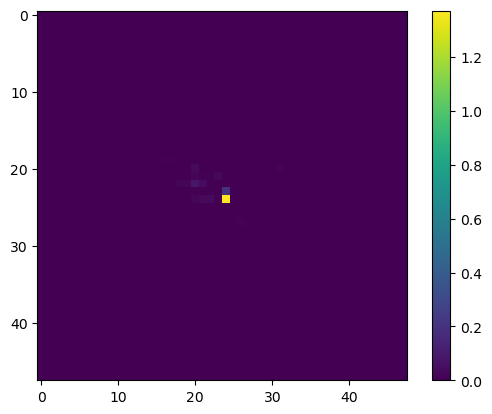

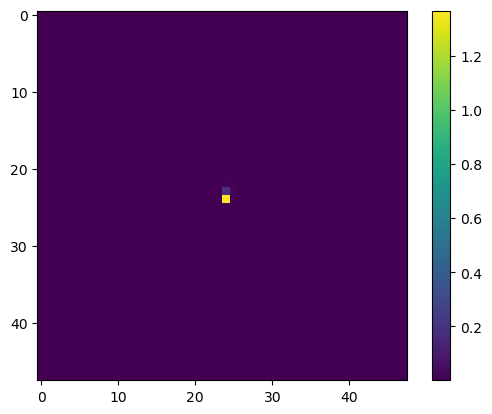

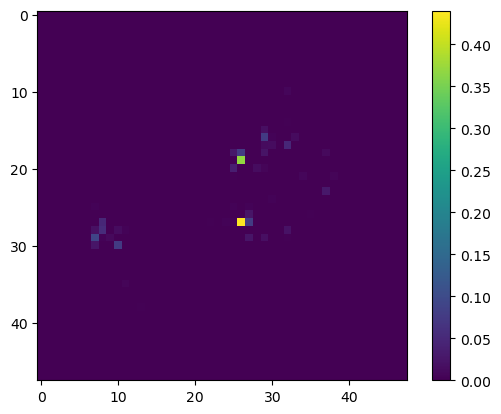

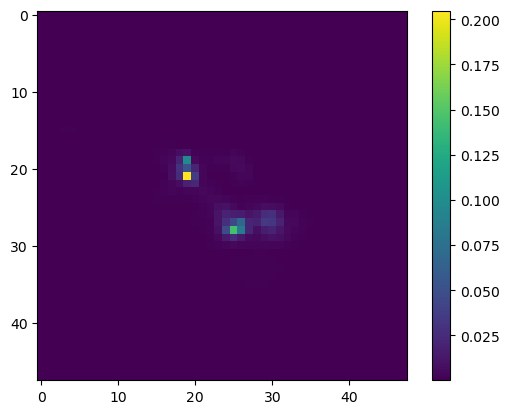

In [10]:
i = 50
plt.imshow(x_test[i])
plt.colorbar()
plt.show()
plt.imshow(bkg_prediction[i])

plt.colorbar()
plt.show()

plt.imshow(signal_results[1][1][i])
plt.colorbar()
plt.show()
plt.imshow(signal_results[1][2][i])

plt.colorbar()
plt.show()

In [11]:
total_loss = []
total_loss.append(mse_loss(x_test.astype('float32'), bkg_prediction.astype('float32')).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X, signal_results[i][2]).numpy())

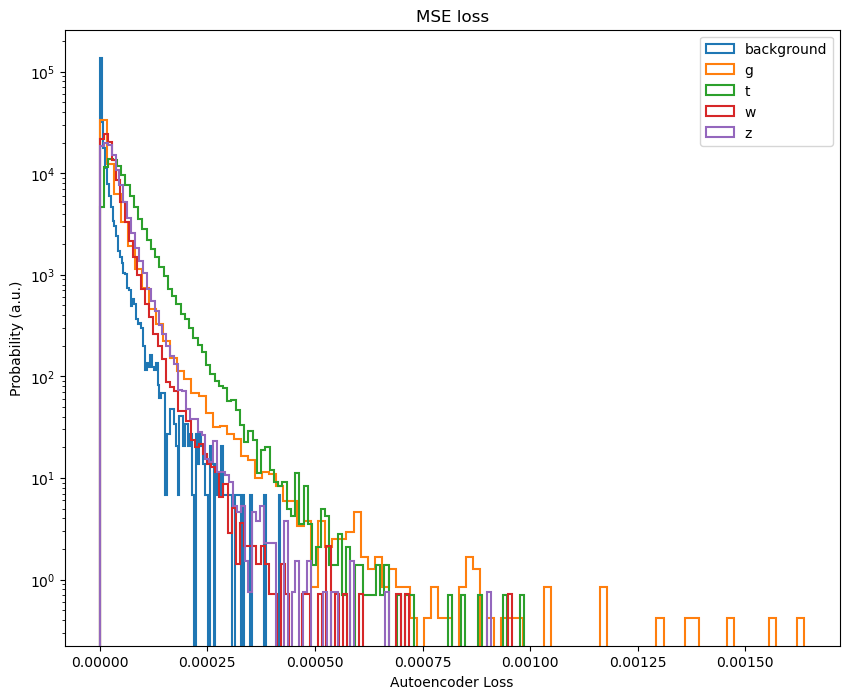

In [12]:
from matplotlib import pyplot as plt

bin_size=100
signal_labels = ["background", "g", "t", "w", "z"]
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5, )#range=[0, 3e4])
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

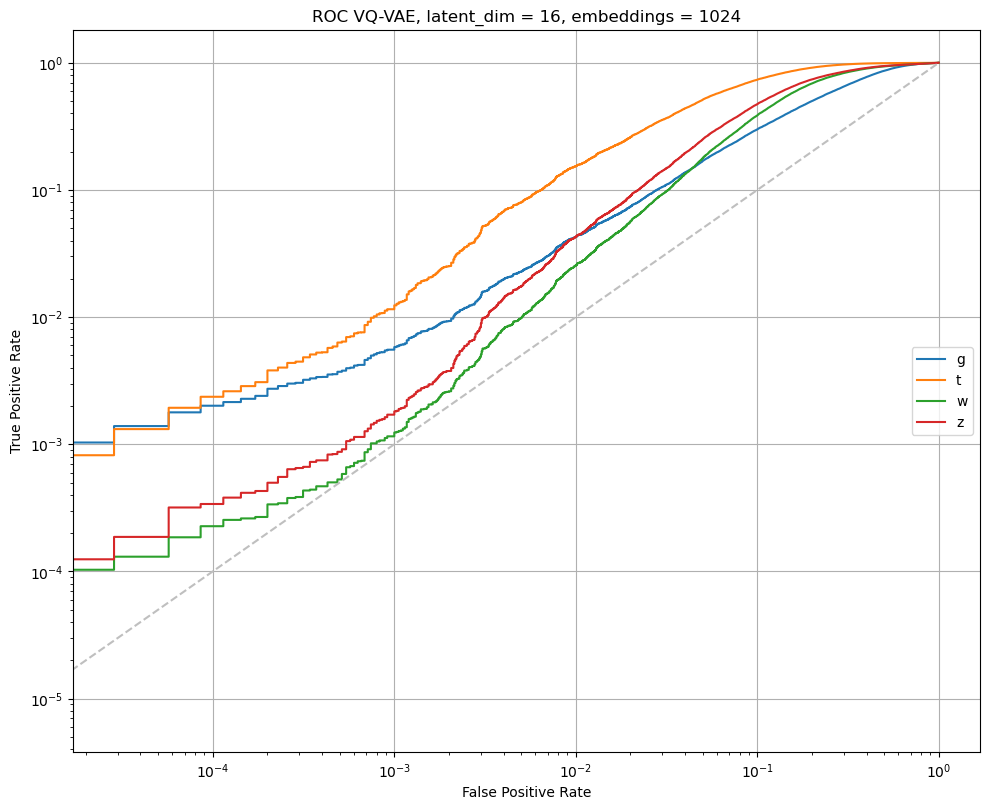

In [13]:
target_background = np.zeros(total_loss[0].shape[0])
#signal_labels = ["background"] + signal_labels
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(tpr_loss, fpr_loss)
    
    plt.plot(fpr_loss,tpr_loss, "-", linewidth=1.5, label = label)#plt.plot(tpr_loss,fpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
#plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title(f"ROC VQ-VAE, latent_dim = {latent_dim}, embeddings = {num_embeddings}")
plt.savefig(output_file+'_roc.jpg')
#plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


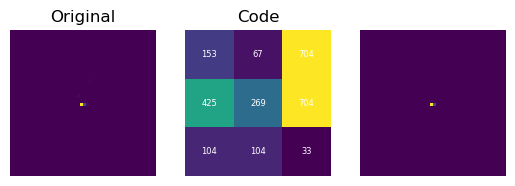

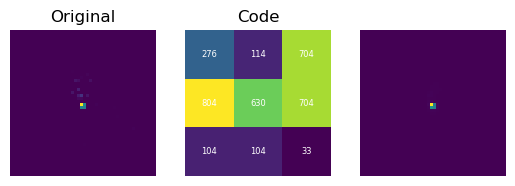

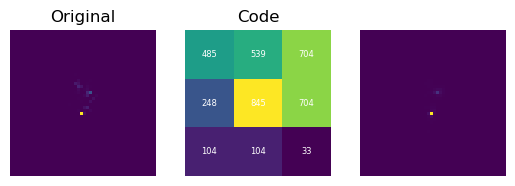

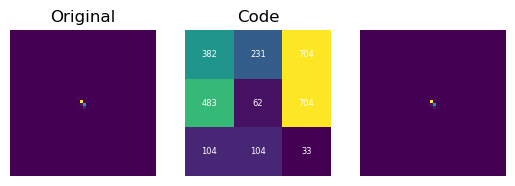

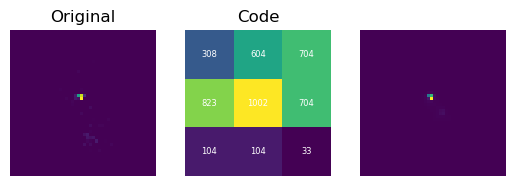

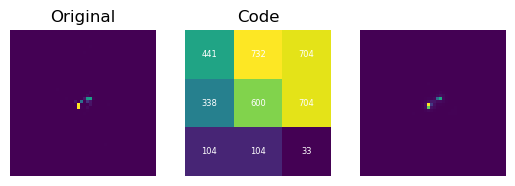

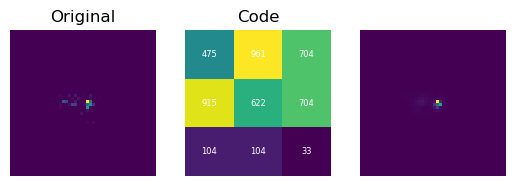

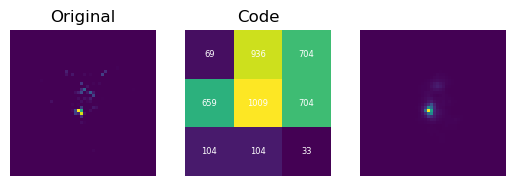

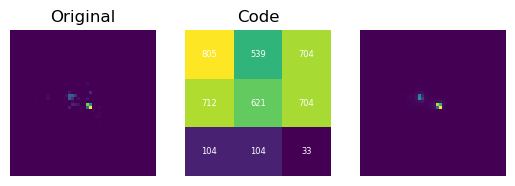

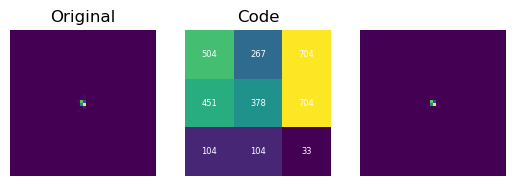

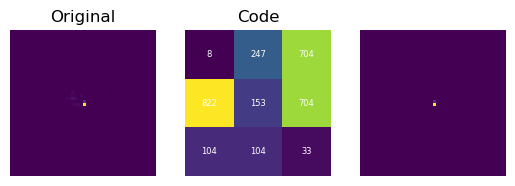

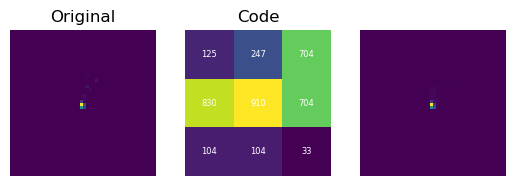

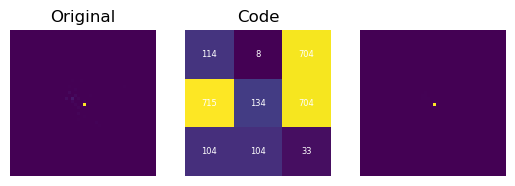

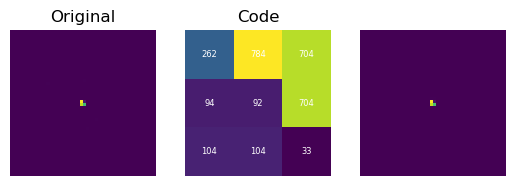

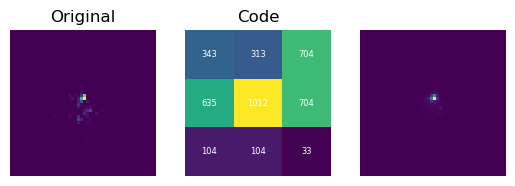

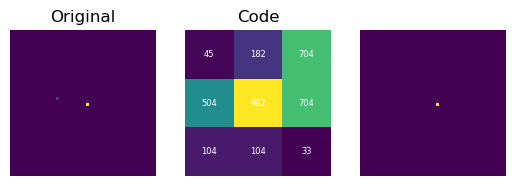

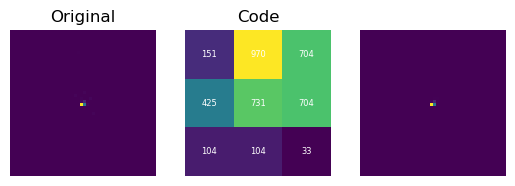

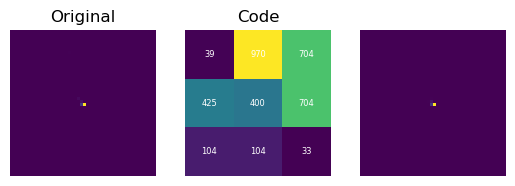

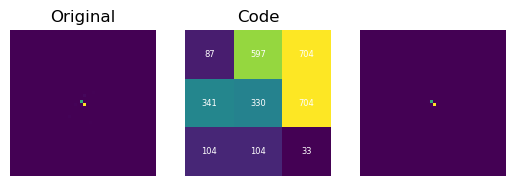

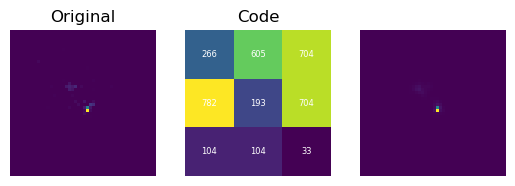

In [14]:
test = x_test[40:60]
encoder = vqvae.get_layer("encoder")
quantizer = vqvae.get_layer("vector_quantizer")
encoded_outputs = encoder.predict(test)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

quantized = quantizer.quantize(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
# print(codebook_indices[0].shape)
# print(quantized[0].shape)



for i in range(len(test)):
    plt.subplot(1, 3, 1)
    plt.imshow(test[i])
    plt.title("Original")
    plt.axis("off")


               
    plt.subplot(1, 3, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    #plt.colorbar()
    for a in range(codebook_indices[i].shape[0]):
        for b in range(codebook_indices[i].shape[1]):
            plt.text(b, a, str(codebook_indices[i][a, b]), ha='center', va='center', color='white', fontsize=6)

    plt.subplot(1,3,3)
    plt.imshow(bkg_prediction[40+i])
    plt.axis("off")
    plt.show()





In [15]:

for embedding in [76]:#np.arange(0,num_embeddngs,1):
    embedding = quantizer.embeddings[:,embedding].numpy()
    print(embedding)
    

[ 1.201423   -1.6531607   2.1613405  -1.6133276   0.7791904   2.680853
 -0.11100329 -1.3716006   1.2202852  -0.91060257  4.634263    1.2021753
  1.4801261  -2.4977863  -2.512678    0.05594496]


In [16]:

encoder = vqvae.get_layer("encoder")
quantizer = vqvae.get_layer("vector_quantizer")
encoded_outputs = encoder.predict(x_test)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
indices = codebook_indices.numpy()
#print(indices)


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step


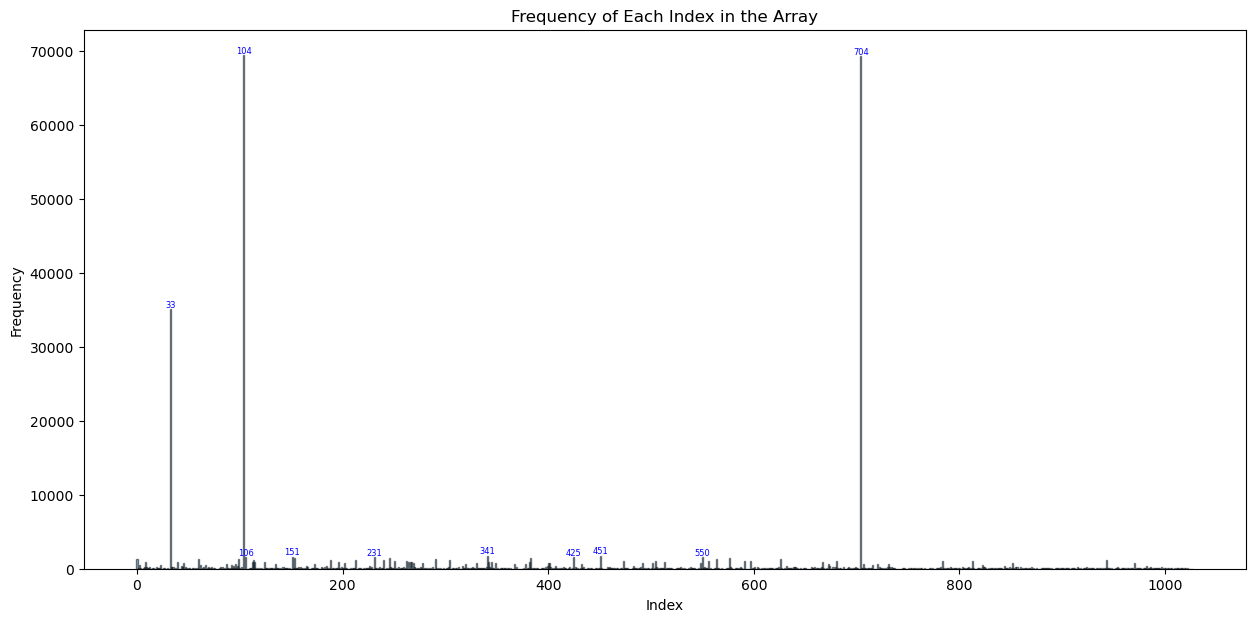

In [17]:

unique, counts = np.unique(indices, return_counts=True)


full_counts = np.zeros(1028, dtype=int)
full_counts[unique] = counts
#full_counts = np.minimum(full_counts,10000)
top_indices = np.argsort(full_counts)[-10:]


plt.figure(figsize=(15, 7))
plt.bar(range(1028),full_counts, width=1.0, edgecolor='black', alpha=0.5, )
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.title('Frequency of Each Index in the Array')


for idx in top_indices:
    plt.text(idx, full_counts[idx], str(idx), ha='center', va='bottom', color='blue', alpha=1, fontsize=6)

plt.show()

4534/4534 ━━━━━━━━━━━━━━━━━━━━ 4s 882us/step


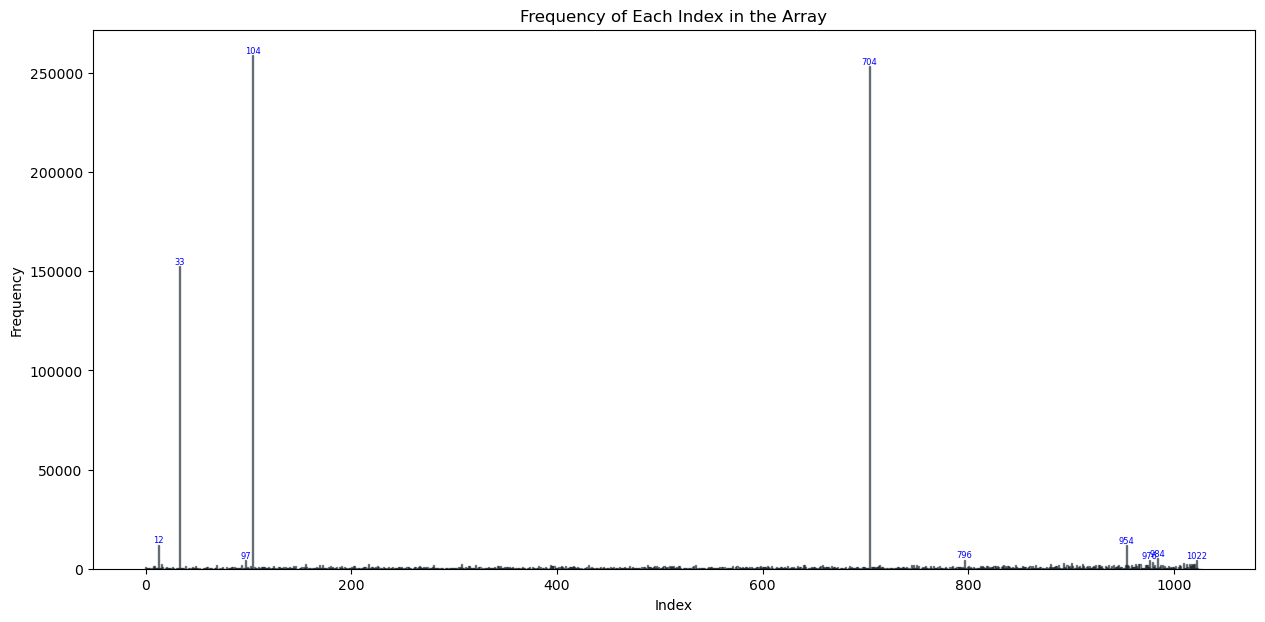

In [18]:

encoder = vqvae.get_layer("encoder")
quantizer = vqvae.get_layer("vector_quantizer")
encoded_outputs = encoder.predict(np.array(signal_results[1][1]))
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
indices = codebook_indices.numpy()
#print(indices)

unique, counts = np.unique(indices, return_counts=True)


full_counts = np.zeros(1028, dtype=int)
full_counts[unique] = counts
#full_counts = np.minimum(full_counts,2000)
top_indices = np.argsort(full_counts)[-10:]


plt.figure(figsize=(15, 7))
plt.bar(range(1028),full_counts, width=1.0, edgecolor='black', alpha=0.5, )
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.title('Frequency of Each Index in the Array')


for idx in top_indices:
    plt.text(idx, full_counts[idx], str(idx), ha='center', va='bottom', color='blue', alpha=1, fontsize=6)

plt.show()

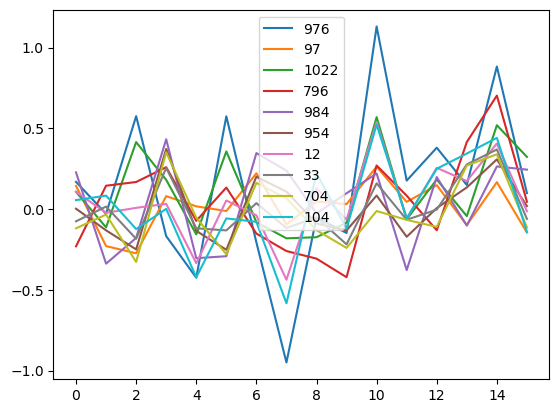

In [19]:

for embedding in top_indices:
    plt.plot(quantizer.embeddings[:,embedding], label=embedding, )
plt.legend()
plt.show()

In [21]:

#total_loss = []
#total_loss.append(mse_test_preds)
loss_test = []
encoded_outputs = encoder.predict(x_test)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
quantized = quantizer.quantize(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))
loss_test.append(mse_loss(encoded_outputs, quantized))

for i, signal_X in enumerate(signal_data):
    encoded_outputs = encoder.predict(signal_X)
    flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
    codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
    quantized = quantizer.quantize(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))
    loss_test.append(mse_loss(encoded_outputs, quantized))
    #total_loss.append(model.predict(quantized))




1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step
4539/4539 ━━━━━━━━━━━━━━━━━━━━ 4s 887us/step
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 4s 871us/step
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 4s 864us/step
4514/4514 ━━━━━━━━━━━━━━━━━━━━ 4s 869us/step


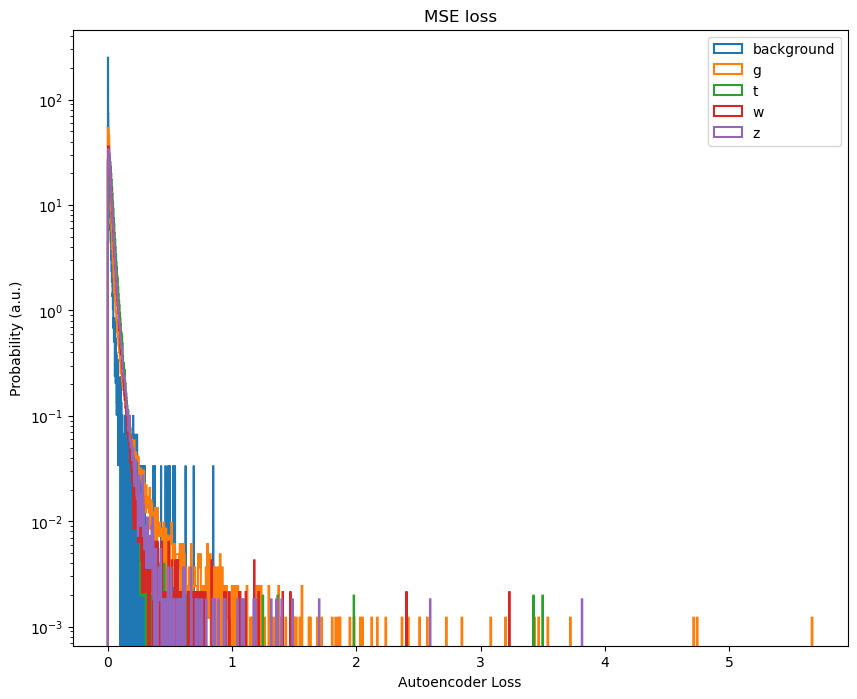

In [33]:
from matplotlib import pyplot as plt

bin_size=100
signal_labels = ["background", "g", "t", "w", "z"]
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(loss_test[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5, )#range=[0, 3e4])
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()


Text(0.5, 1.0, 'AE')

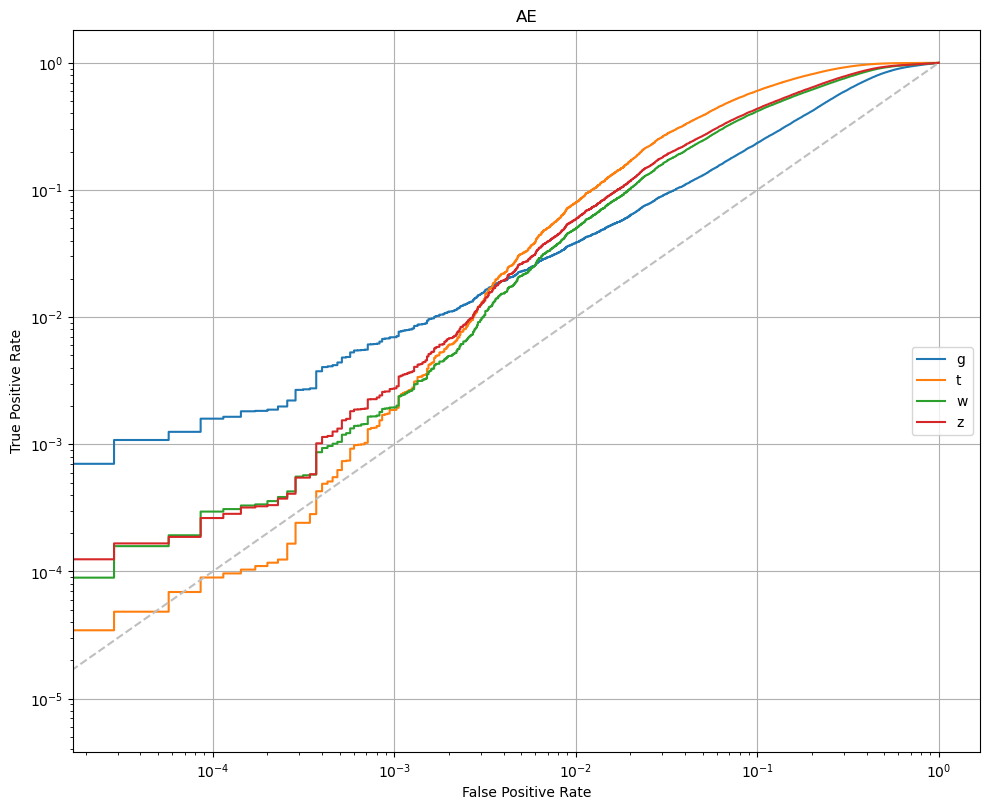

In [28]:
# Define labels and background
target_background = np.zeros(loss_test[0].shape[0])
#signal_labels = ["background"] + signal_labels
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(loss_test[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((loss_test[i], loss_test[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(tpr_loss, fpr_loss)
    
    plt.plot(fpr_loss,tpr_loss, "-", linewidth=1.5, label = label)#plt.plot(tpr_loss,fpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
#plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("VQVAE")
#plt.savefig(output_file+'_roc.jpg')
#plt.show()

In [40]:
labels = ["q", "g", "t", "w", "z"]

files = ["data/q_dataset.h5", "data/g_dataset.h5", "data/t_dataset.h5","data/w_dataset.h5","data/z_dataset.h5"]
data = []
for i, label in enumerate(labels):
    with h5py.File(files[i], 'r') as file:
        test_data = np.array(file['Data'])
    encoded_outputs = encoder.predict(test_data)
    flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
    codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

    quantized = quantizer.quantize(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))
    
    data.append(quantized)
    #data.append(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))
label_list = []
for i, label in enumerate(labels):
    label_list.extend([label] * len(data[i]))
#data = list(itertools.chain.from_iterable(data))

4371/4371 ━━━━━━━━━━━━━━━━━━━━ 4s 887us/step
4539/4539 ━━━━━━━━━━━━━━━━━━━━ 4s 881us/step
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 4s 883us/step
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 4s 885us/step
4514/4514 ━━━━━━━━━━━━━━━━━━━━ 4s 886us/step


In [41]:
data = np.concatenate(data)
print(data.shape)
#data = np.array(itertools.chain.from_iterable(data))

(720000, 3, 3, 16)


In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_list)

X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

model = keras.models.Sequential([
    keras.Input(shape=(3,3,latent_dim, 1)),
    layers.Conv3D(64, (2,2,2), activation='relu'),
    layers.MaxPooling3D((1,1,2)),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(labels), activation='softmax')
])

# model = keras.models.Sequential([
#     keras.Input(shape=(3,3,1)),
#     #layers.Conv2D(64, (3,3),padding='same', activation='relu'),
#     layers.Flatten(),
#     layers.BatchNormalization(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(16, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(len(labels), activation='softmax')
# ])



model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=15, batch_size=256)

Epoch 1/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 955us/step - accuracy: 0.4773 - loss: 1.3104
Epoch 2/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 980us/step - accuracy: 0.5290 - loss: 1.1760
Epoch 3/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 967us/step - accuracy: 0.5369 - loss: 1.1625
Epoch 4/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - accuracy: 0.5418 - loss: 1.1530
Epoch 5/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 970us/step - accuracy: 0.5459 - loss: 1.1447
Epoch 6/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - accuracy: 0.5475 - loss: 1.1415
Epoch 7/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 974us/step - accuracy: 0.5506 - loss: 1.1349
Epoch 8/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 961us/step - accuracy: 0.5522 - loss: 1.1314
Epoch 9/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 965us/step - accuracy: 0.5542 - loss: 1.1294
Epoch 10/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 959us/step - accuracy: 0.5547 - loss: 1.1258
Epoch 11/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 956us/step - accuracy: 0.5557 - loss: 1.1233
Epoch 12

4500/4500 ━━━━━━━━━━━━━━━━━━━━ 4s 715us/step - accuracy: 0.5655 - loss: 1.0877
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 3s 710us/step


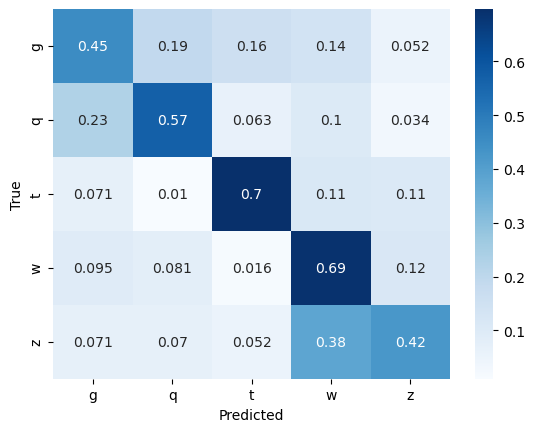

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

loss, accuracy = model.evaluate(X_test, y_test)


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


cm = confusion_matrix(y_test, y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


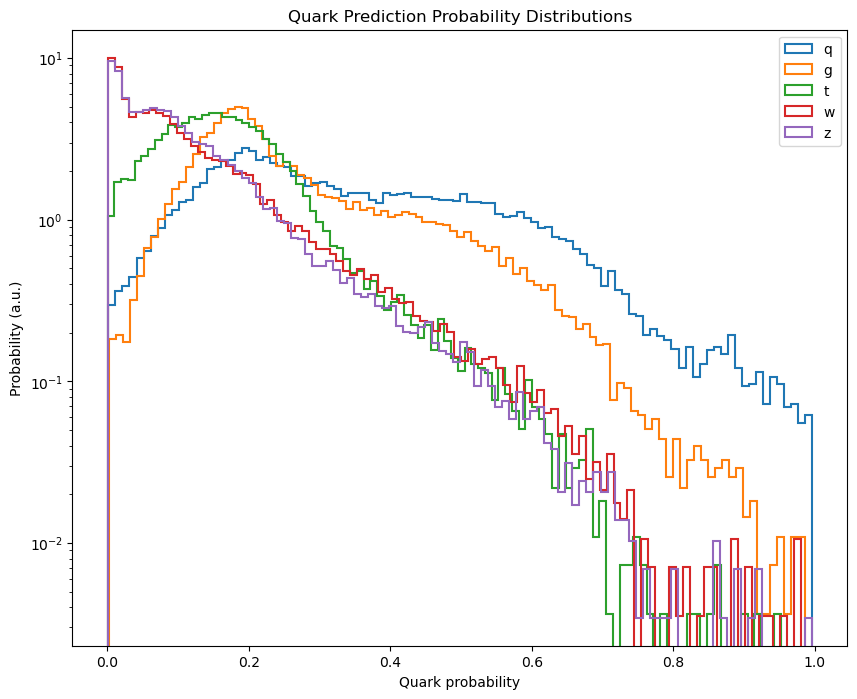

In [44]:
import numpy as np
from matplotlib import pyplot as plt

labels = ["q", "g", "t", "w", "z"]
quark_probabilities = y_pred[:, 0]


bin_size = 100

plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    class_prob = quark_probabilities[y_test == i]
    
    plt.hist(class_prob, bins=bin_size, label=label, density=True, histtype='step', fill=False, linewidth=1.5)

plt.yscale('log')
plt.xlabel('Quark probability')
plt.ylabel('Probability (a.u.)')
plt.title('Quark Prediction Probability Distributions')
plt.legend(loc='best')
plt.show()

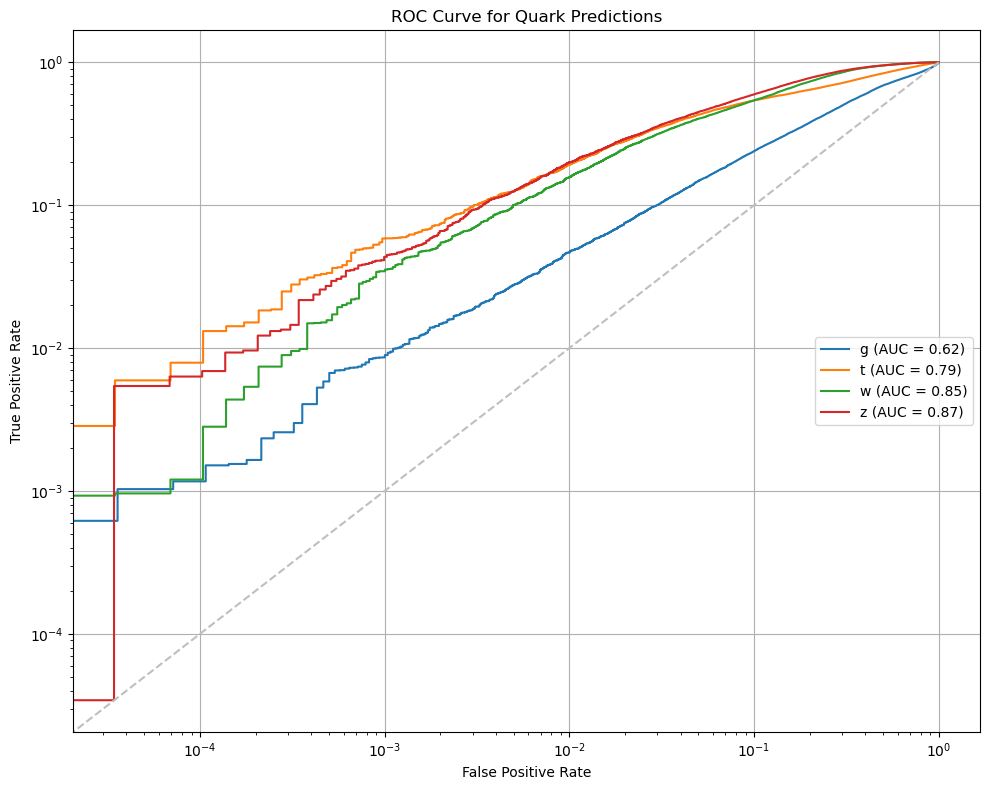

In [45]:
# Define labels and background
signal_labels = ["background", "g", "t", "w", "z"]
background_label = 0  # Assuming 'q' is the background class

# Initialize target for background
target_background = np.zeros(np.sum(y_test == background_label))

# Prepare the figure
plt.figure(figsize=(10, 8))


for i, label in enumerate(signal_labels):
    if i == background_label:
        continue  # Skip background events
    
    trueVal = np.concatenate((np.ones(np.sum(y_test == i)), target_background))  # anomaly=1, bkg=0
    predVal_loss = np.concatenate((quark_probabilities[y_test == i], quark_probabilities[y_test == background_label]))

    tpr_loss, fpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", linewidth=1.5, label=f'{label} (AUC = {auc_loss:.2f})')
    
plt.semilogx()
plt.semilogy()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Quark Predictions')
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.show()

In [83]:
def get_model(latent_dim=16):
    latent_inputs = keras.Input(shape=(3,3,latent_dim, 1))
    x = layers.Conv3D(64, (2,2,2), activation='relu')(latent_inputs)
    x = layers.MaxPooling3D((1,1,2))(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(latent_inputs, x, name="decoder")

def get_model(latent_dim=16):
    latent_inputs = keras.Input(shape=(3,3,latent_dim, 1))
    x = layers.Conv3D(64, (2,2,2), activation='relu', padding='same')(latent_inputs)
    x = layers.MaxPooling3D((1,1,2))(x)
    x = layers.Conv3D(128, (2,2,2), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((1,1,2))(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(latent_inputs, x, name="decoder")
def get_model(latent_dim=16):
    latent_inputs = keras.Input(shape=(3,3,latent_dim, 1))
    x = layers.BatchNormalization()(latent_inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(10, activation='relu')(x)

    x = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(latent_inputs, x, name="decoder")


def get_model(latent_dim=16):
    latent_inputs = keras.Input(shape=(3,3,latent_dim, 1))
    x = layers.BatchNormalization()(latent_inputs)
    x = layers.Conv3D(filters=1, kernel_size=(1, 1, 16), padding='same', activation='relu')(x)
    x = layers.Conv3D(filters=1, kernel_size=(1, 1, 16), padding='valid', activation='relu')(x)

    
    #x = layers.Conv3D(filters=1, kernel_size=(1, 1, 16), padding='valid', activation='relu')(x)
    #x = layers.Conv3D(filters=1, kernel_size=(1, 1, 2), padding='valid', activation='relu')(x)


    x = layers.Flatten()(x)

    x = layers.Dense(8, activation='relu')(x)
    x = layers.Dense(8, activation='relu')(x)
    x = layers.Dense(4, activation='relu')(x)


    x = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(latent_inputs, x, name="decoder")

print(get_model().summary())


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 3, 3, 16, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 3, 3, 16, 1)    │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_58 (Conv3D)              │ (None, 3, 3, 16, 1)    │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_59 (Conv3D)              │ (None, 3, 3, 1, 1)     │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 8)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231 (924.00 B)

 Trainable params: 229 (916.00 B)

 Non-trainable params: 2 (8.00 B)

None


In [84]:
encoder = vqvae.get_layer("encoder")
quantizer = vqvae.get_layer("vector_quantizer")
encoded_outputs = encoder.predict(x_train)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

quantized = quantizer.quantize(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))
print(quantized.shape)

mse_losses = mse_loss(x_train, vqvae.predict(x_train))

3278/3278 ━━━━━━━━━━━━━━━━━━━━ 3s 883us/step
(104887, 3, 3, 16)
3278/3278 ━━━━━━━━━━━━━━━━━━━━ 3s 941us/step


In [86]:
model = get_model(latent_dim)


var = np.var(mse_losses)
model.compile(loss=lambda y_true, y_pred: tf.reduce_mean(tf.square(y_true - y_pred))/var, optimizer=keras.optimizers.Adam())
model.fit(quantized, mse_losses, epochs = 100,  batch_size=512, callbacks=[
         keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta = 0.00),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)])

Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 725364480.0000 - learning_rate: 0.0010
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 548548.7500 - learning_rate: 0.0010
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134532.2188 - learning_rate: 0.0010
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60745.1680 - learning_rate: 0.0010
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33716.0195 - learning_rate: 0.0010
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20719.0801 - learning_rate: 0.0010
Epoch 7/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14146.5605 - learning_rate: 0.0010
Epoch 8/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10364.3096 - learning_rate: 0.0010
Epoch 9/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7529.8896 - learning_rate: 0.0010
Epoch 10/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5814.2344 - learning_rate: 0.0010
Epoch 11/100
205/205 ━━━━━━━━━━━━

In [87]:
encoded_outputs = encoder.predict(x_test)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

quantized = quantizer.quantize(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))
mse_test_preds = model.predict(quantized)

1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [88]:
total_loss = []
total_loss.append(mse_test_preds)
for i, signal_X in enumerate(signal_data):
    encoded_outputs = encoder.predict(signal_X)
    flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
    codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
    
    quantized = quantizer.quantize(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))
    total_loss.append(model.predict(quantized))


4539/4539 ━━━━━━━━━━━━━━━━━━━━ 4s 887us/step
4539/4539 ━━━━━━━━━━━━━━━━━━━━ 4s 770us/step
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 4s 876us/step
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 3s 716us/step
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 4s 861us/step
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 4s 773us/step
4514/4514 ━━━━━━━━━━━━━━━━━━━━ 4s 876us/step
4514/4514 ━━━━━━━━━━━━━━━━━━━━ 3s 767us/step


Text(0.5, 1.0, 'ROC VQ-VAE, latent_dim = 16, embeddings = 1024')

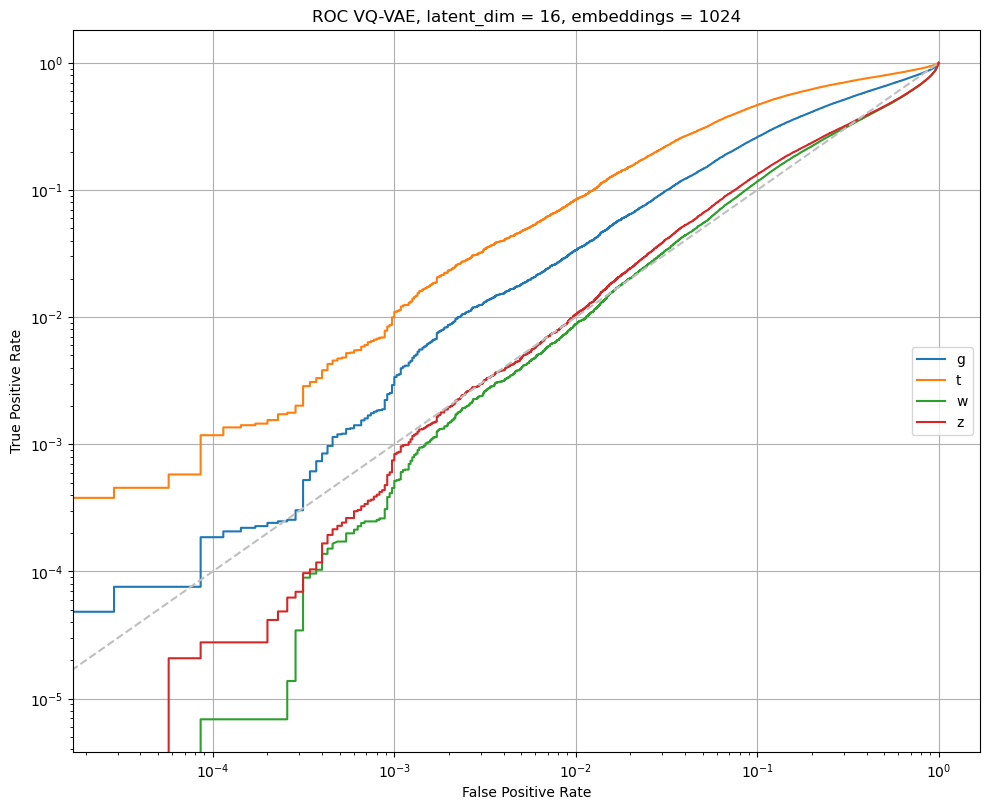

In [89]:
target_background = np.zeros(total_loss[0].shape[0])
#signal_labels = ["background"] + signal_labels
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(tpr_loss, fpr_loss)
    
    plt.plot(fpr_loss,tpr_loss, "-", linewidth=1.5, label = label)#plt.plot(tpr_loss,fpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
#plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title(f"ROC VQ-VAE, latent_dim = {latent_dim}, embeddings = {num_embeddings}")
#plt.savefig(output_file+'_roc.jpg')
#plt.show()